In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import cv2
import math
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from classification_functions import *

In [2]:
#Load data
base_path = "cf10/"
train_data,train_labels = load_cf10_data(base_path, type="train")
test_data, test_labels =  load_cf10_data(base_path, type="test")

assert(len(train_data) == len(train_labels))
assert(len(test_data) == len(test_labels))
print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


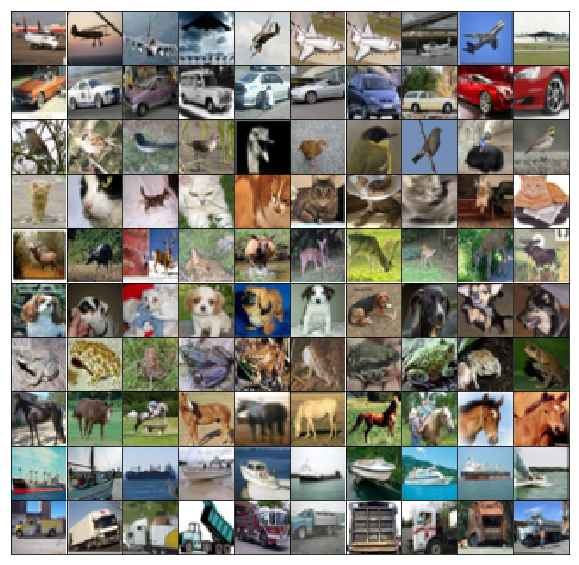

In [3]:
#Visualize data
visualize_cf10(train_data,train_labels)

F:\Github\Projects\ClassificationTensorFlow\classification_functions.py:178: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(test_labels!=None):
F:\Github\Projects\ClassificationTensorFlow\classification_functions.py:184: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(test_labels!=None):


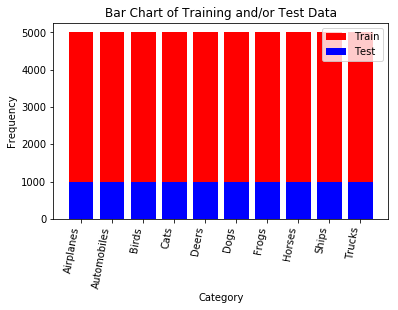

In [4]:
#Plot data
plot_cf10_data(train_labels,test_labels)

In [5]:
### Augment training data and display augmented data

data,labels = augment_data(train_data,train_labels,100)
train_data = np.vstack((train_data, data))
train_labels = np.hstack((train_labels,labels))
print(train_data.shape)
print(train_labels.shape)

(50500, 32, 32, 3)
(50500,)


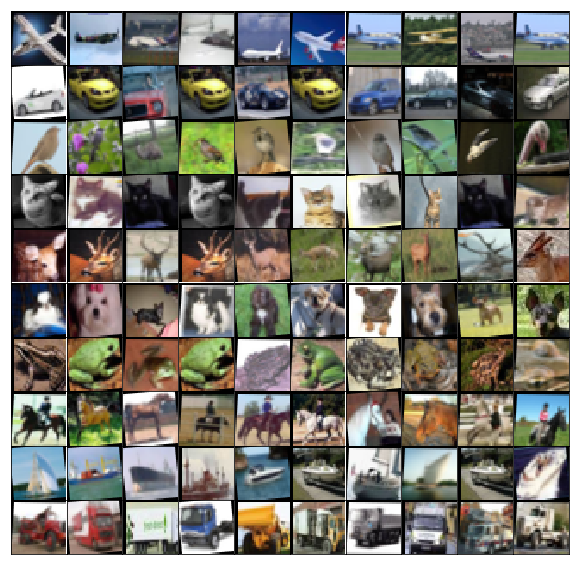

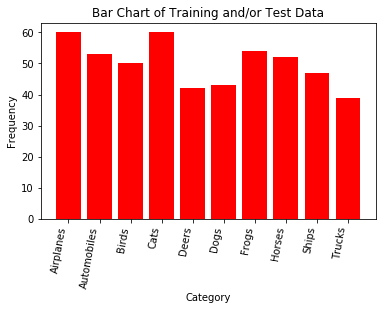

In [6]:
visualize_cf10(train_data[50000:], train_labels[50000:])
plot_cf10_data(train_labels[50000:])

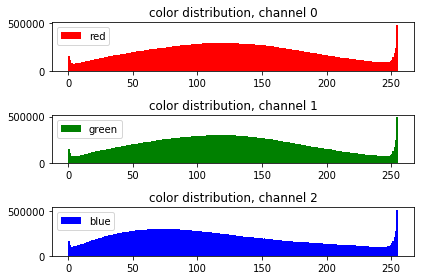

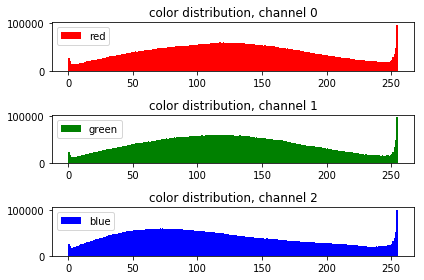

In [7]:
#Plot colour distribution of all the data

plot_color_dist(train_data)
plt.show()
plot_color_dist(test_data)
plt.show()

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
dropout_rate = tf.placeholder(tf.float32,[], (None))
one_hot_y = tf.one_hot(y, 10)

EPOCHS = 1
BATCH_SIZE = 128

learning_rate = 0.001
dropout = 0.5

logits = train_model(x,dropout_rate=dropout_rate)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

(?, 10)


In [9]:


correct_prediction = tf.equal(tf.argmax(logits, 1, name="logits"), tf.argmax(one_hot_y, 1, name="labels"))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



def evaluate(X_data, y_data):
    """Evaluate accuracy of training
    Args:
        X_data: ndarray of training X data
        y_data: ndarray of labels
    Returns: Accuracy
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    generator = image_generator(X_data,y_data,BATCH_SIZE)
    for offset in range(math.floor(num_examples/BATCH_SIZE)):
        batch_x, batch_y = next(generator)
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [11]:

X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)


saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    count=1
    for i in range(EPOCHS):
        generator = image_generator(X_train,y_train,BATCH_SIZE)
        print("Epoch {}/{}".format(i+1,EPOCHS))
        
        for offset in range(math.floor(num_examples/BATCH_SIZE)):
            batch_x, batch_y = next(generator)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout_rate: dropout})
            if(count%10==0):
                cross_entropy_loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, dropout_rate: dropout}) 
                print("Cross Entropy loss count {}: {}".format(count,cross_entropy_loss))
            count+=1
            if(count%80==0):
                validation_accuracy = evaluate(X_valid, y_valid)
                print("EPOCH {} ...".format(i+1))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
        
                
            
      
    saver.save(sess, './mynetwork')
    print("Model saved")

Training...


TypeError: 'generator' object is not callable

In [ ]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test_data, test_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    